In [1]:
import torch
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
from math import sin, atan, copysign

def clamp(x:float, lo:float, hi:float) -> float:
    if x < lo:
        return lo
    elif x > hi:
        return hi
    return x

class parabolaSimulator:
    def __init__(self):
        self.x = 0
        self.x_dot = 0

        self.dt:float = 1/100
        self.rateLimit:float = 1.0
        self.g:float = 2

    def step(self, input:float) -> None:
        self.actuator = clamp(input, -self.rateLimit, self.rateLimit)
        # self.x_ddot = self.g*sin(atan(copysign(1, x)*1.2*pow(abs(self.x), 0.2)))+self.actuator
        self.x_ddot = self.g*sin(atan(2*self.x))+self.actuator
        self.x_dot += self.dt * self.x_ddot/10# slow doooown
        self.x += self.dt * self.x_dot
        self.x = clamp(self.x, -.1, .1)
        


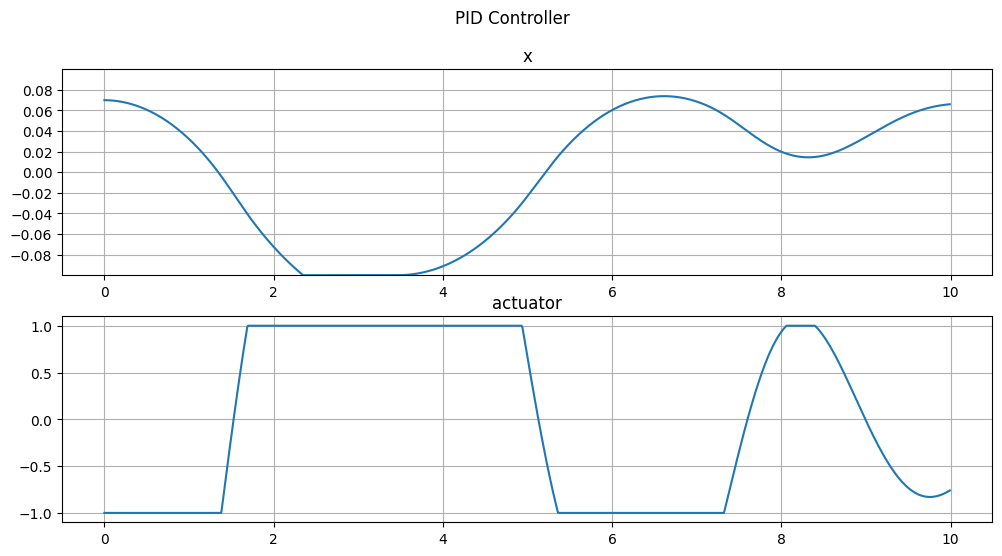

In [3]:

log_x = []
log_t = []
log_act = []


pid_p=50
pid_i=5
pid_d=10

I=0
setpoint = lambda t:-0.05+t*0.01
p = parabolaSimulator()
p.x=0.07
prev_error = 0
for i in range(100*10):
  x=p.x
  s = setpoint(i*p.dt)
  p_term = s-x
  i_term= I
  I+=(s-x)*p.dt
  d_term = (p_term-prev_error)/p.dt
  actuator = p_term*pid_p+i_term*pid_i+d_term*pid_d
  p.step(actuator)

  log_x.append(clamp(x, -1, 1))
  log_t.append(i*p.dt)
  log_act.append(clamp(actuator, -1, 1))
  prev_error = p_term

fig, ax = plt.subplots(2)

fig.suptitle('PID Controller')
ax[0].set_title('x')
ax[0].plot(log_t, log_x)
ax[0].set_yticks(torch.arange(-1, 1, 0.02))
ax[0].grid(True)
ax[0].set_ylim(-0.1, 0.1)

ax[1].set_title('actuator')
ax[1].plot(log_t, log_act)
ax[1].set_ylim(-1.1, 1.1)
ax[1].grid(True)

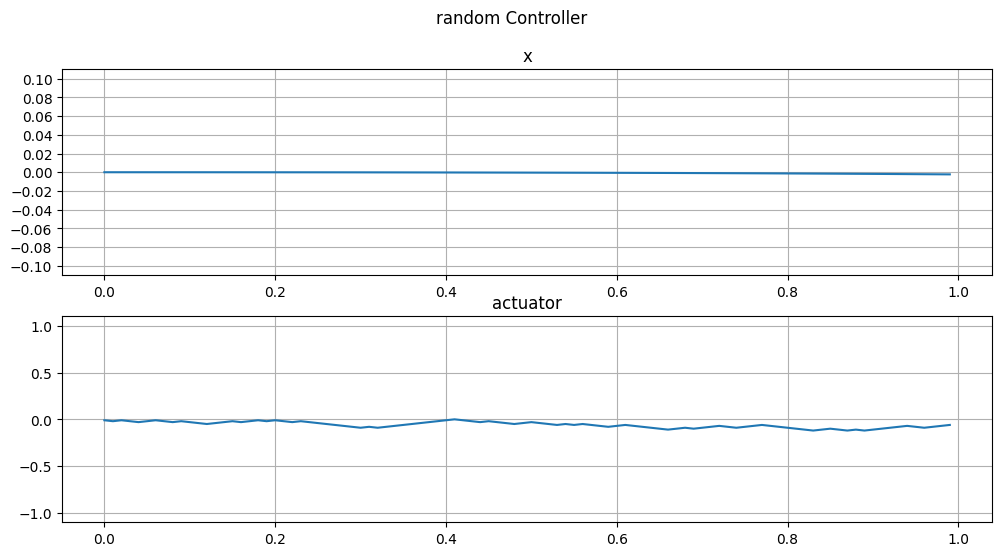

In [4]:
import random

def generate_control_sample(x0:float, act0:float, actuator_step:float, ts:int):
  """ Generates logs of form ([t], [x], [actuator]) where actuator does a random walk per time stamp """
  x = x0
  log_x = []
  log_act = []
  log_t = []
  system = parabolaSimulator()
  system.x = x0
  actuator = act0
  for i in range(ts):
    actuator += actuator_step*[-1,1][random.randint(0, 1)]
    system.step(actuator)


    log_t.append(i*system.dt)
    log_x.append(system.x)
    log_act.append(actuator)
  return log_t, log_x, log_act

log_t, log_x, log_act = generate_control_sample(0., 0, 0.01, 100*1)
fig, ax = plt.subplots(2)

fig.suptitle('random Controller')
ax[0].set_title('x')
ax[0].plot(log_t, log_x)
ax[0].set_yticks(torch.arange(-1, 1, 0.02))
ax[0].grid(True)
ax[0].set_ylim(-0.11, 0.11)

ax[1].set_title('actuator')
ax[1].plot(log_t, log_act)
ax[1].set_ylim(-1.1, 1.1)
ax[1].grid(True)

In [5]:
import torch
from torch import nn
tprev = 100*1
tnext = 100*5
timeLength = tprev+tnext
xMerge = 20
actMerge = 50
sampleLength = tprev//xMerge+timeLength//actMerge
outputLength = tnext//xMerge
print(f"sampleLength: {sampleLength}")
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(sampleLength, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, outputLength),
            nn.Tanh()
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

sampleLength: 17


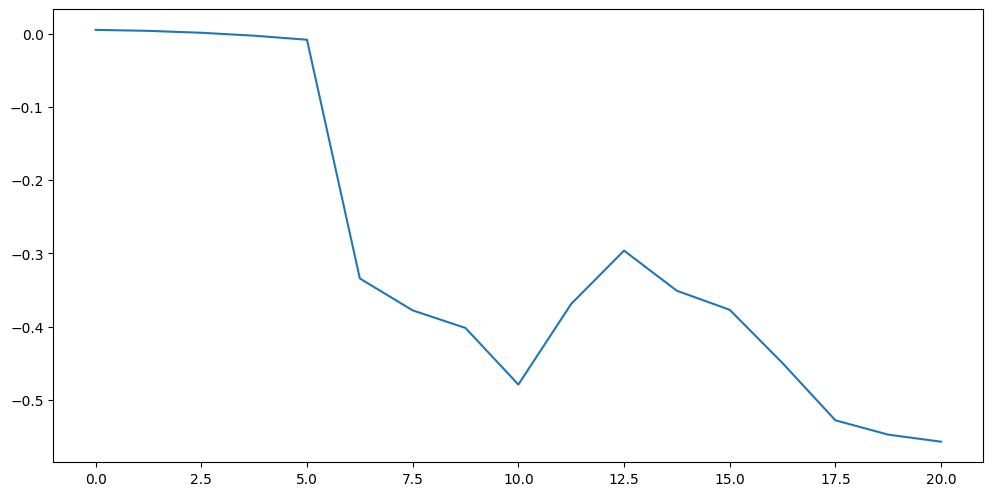

In [6]:

def generateNetworkIOSample(x0:float=0.0, cmd:float=0.0):
  """Generates (input, output) where input = (xprev, actprev, actfut) and output = xfut"""
  t, x, act = generate_control_sample(x0, cmd, 0.01, timeLength)
  assert(len(x)%xMerge==0)
  assert(len(act)%actMerge==0)
  # print(len(x), len(t), len(act))
  xprev = torch.tensor(x[:tprev]).reshape(tprev//xMerge, xMerge).mean(dim=1)
  actprev = torch.tensor(act[:tprev]).reshape(tprev//actMerge, actMerge).mean(dim=1)
  xfut = torch.tensor(x[tprev:]).reshape(tnext//xMerge, xMerge).mean(dim=1)
  actfut = torch.tensor(act[tprev:]).reshape(tnext//actMerge, actMerge).mean(dim=1)

  # print(xprev.shape)
  # print(actprev.shape)
  # print(xfut.shape)
  # print(actfut.shape)
  return (xprev, actprev, actfut), xfut

#example usage
i, o = generateNetworkIOSample(0.05*(1-2*random.random()), 0.5*(1-2*random.random()))

plt.plot(torch.linspace(0, 20, sampleLength), torch.concat(i))

In [7]:
from torch.utils.data import Dataset, DataLoader
class SimDataset(Dataset):
    def __init__(self, length, i, o):
        self.len = length
        self.i = i
        self.o = o

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.i[idx], self.o[idx]

In [9]:
from tqdm import tqdm
def random_data_dataset(length):
    raw_in = [generateNetworkIOSample(0.05*(1-2*random.random()), 0.5*(1-2*random.random())) for _ in tqdm(range(length))]

    i_data = []
    o_data = []
    for inn, out in tqdm(raw_in):
        i_data.append(torch.concat(inn))
        o_data.append(out)
    return SimDataset(length, i_data, o_data)


in_set = random_data_dataset(10000)
out_set = random_data_dataset(1000)


100%|██████████| 1000/1000 [00:00<00:00, 148481.45it/s]


In [10]:
train_dataloader = DataLoader(in_set, batch_size=64, drop_last=True)
test_dataloader = DataLoader(out_set, batch_size=64)

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer, debug):
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)*10000

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if debug:
        loss = loss.item()
        print(f"loss: {loss:.5f}")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()*10000

    test_loss /= num_batches
    print(f"Test  loss: {test_loss:.5f} \n")

model = NeuralNetwork()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
epochs = 100
print(len(train_dataloader))
print(len(test_dataloader))
for t in range(epochs):
    if t%10 == 0:
        print(f"Epoch {t}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, t%10==0)
    if t%10 == 0:
        test_loop(test_dataloader, model, loss_fn)
print("Done!")

156
16
Epoch 0
-------------------------------
loss: 109.78429
Test  loss: 112.29424 

Epoch 10
-------------------------------
loss: 3.54857
Test  loss: 3.37261 

Epoch 20
-------------------------------
loss: 0.82392
Test  loss: 0.84473 

Epoch 30
-------------------------------
loss: 0.50211
Test  loss: 0.48104 

Epoch 40
-------------------------------
loss: 0.32088
Test  loss: 0.29933 

Epoch 50
-------------------------------
loss: 0.20065
Test  loss: 0.19914 

Epoch 60
-------------------------------
loss: 0.15380
Test  loss: 0.15539 

Epoch 70
-------------------------------
loss: 0.12502
Test  loss: 0.12600 

Epoch 80
-------------------------------
loss: 0.10473
Test  loss: 0.10536 

Epoch 90
-------------------------------
loss: 0.08994
Test  loss: 0.08955 

Done!


torch.Size([25])
2.20477522816509e-06


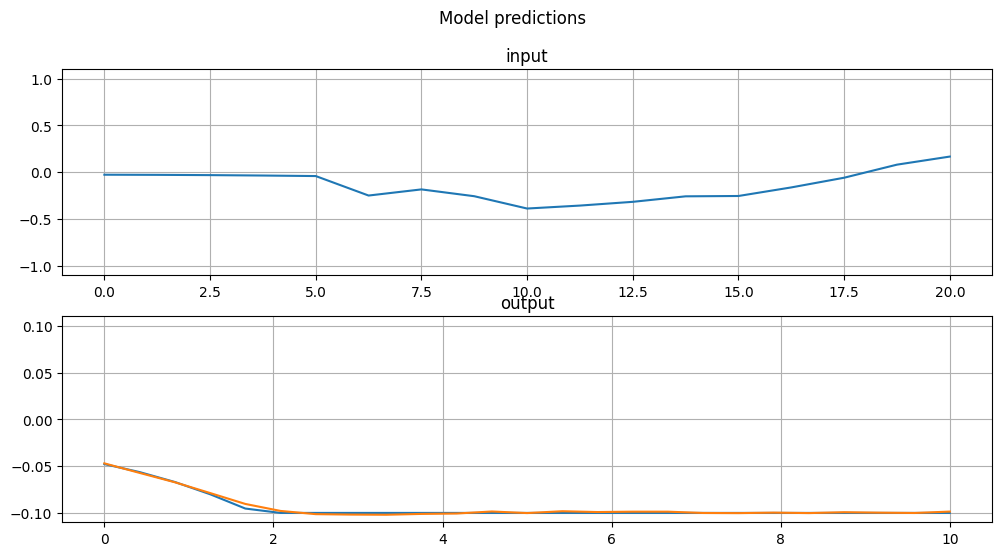

In [13]:
i, o = generateNetworkIOSample(0.05*(1-2*random.random()), 0.5*(1-2*random.random()))

with torch.no_grad():
  o2 = model(torch.concat(i))
print(o2.shape)
print(nn.MSELoss()(o, o2).item())
# plt.plot(torch.linspace(0, 20, sampleLength), torch.concat(i))
fig, ax = plt.subplots(2)

fig.suptitle('Model predictions')
ax[0].set_title('input')
ax[0].plot(torch.linspace(0, 20, sampleLength), torch.concat(i))
ax[0].grid(True)
ax[0].set_ylim(-1.1, 1.1)

ax[1].set_title('output')
ax[1].plot(torch.linspace(0, 10, outputLength), o)
ax[1].plot(torch.linspace(0, 10, outputLength), o2)
ax[1].set_ylim(-.11, .11)
ax[1].grid(True)

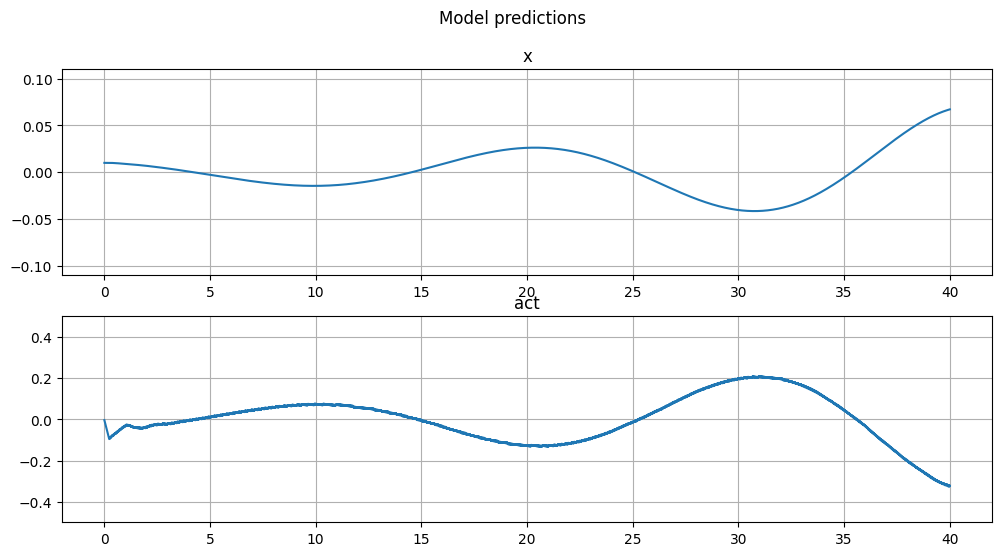

In [17]:

def weightBias(x):#wb:[0,1]-> [0,1]
  return 1 if 0.5<x<0.6 else 0
def scale(x):
  return copysign(1, x)*abs(x)
class Controller:
  def __init__(self, model, simulator):
    self.model=model
    self.simulator:parabolaSimulator = simulator

    self.x_log = []
    self.act_log = []
    self.lastActuator = 0
  def run_step(self, setpoint):
    act = self._get_control_setpoint(setpoint)
    self.simulator.step(act)

    self.x_log.append(self.simulator.x)
    self.act_log.append(act)
    self.lastActuator = act
  def _get_control_setpoint(self, setpoint):
    if len(self.x_log)<tprev:
      self.x_log = [self.simulator.x]*tprev
      self.act_log = [0.]*tprev
    xprev = torch.tensor(self.x_log[-tprev:]).reshape(tprev//xMerge, xMerge).mean(dim=1)
    actprev = torch.tensor(self.act_log[-tprev:]).reshape(tprev//actMerge, actMerge).mean(dim=1)
    xfut = setpoint*torch.ones(tnext//xMerge)
    actfut = self.lastActuator*torch.ones(tnext//actMerge)
    xfut2 = model(torch.cat((xprev, actprev, actfut)))

    sm = 0
    for i in range(xfut.shape[0]):
      sm += scale(xfut2[i]-xfut[i])*weightBias(i/xfut.shape[0])
    return self.lastActuator-0.004 if sm>0 else self.lastActuator+0.0038

sim = parabolaSimulator()
sim.x = .01
c = Controller(model, sim)

st = 100*40
for _ in range(st):
  c.run_step(0)

fig, ax = plt.subplots(2)

fig.suptitle('Model predictions')
ax[0].set_title('x')
ax[0].plot(torch.linspace(0, st//100, st), c.x_log[tprev:])
ax[0].grid(True)
ax[0].set_ylim(-.11, .11)

ax[1].set_title('act')
ax[1].plot(torch.linspace(0, st//100, st), c.act_log[tprev:])
ax[1].set_ylim(-.5, .5)
ax[1].grid(True)